In [22]:
from collections import deque
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import numpy as np
import optax
import distrax
import haiku as hk

import tensorflow as tf
import tensorflow_datasets as tfds

from lfiax.flows.nsf import make_nsf

from typing import (
    Any,
    Iterator,
    Mapping,
    Optional,
    Tuple,
)

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # sample random gamma noise
    n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
        seed=keys[1], sample_shape=[len(d), len(priors)]
    )

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:, 1], 0)
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = priors[:, 1]

    return y, ygrads

def sim_true_linear_jax(d: Array, theta_true: Array, key: PRNGKey):
    # TODO: check that `theta_true` is the correct size
    # TODO: check that function works as expected
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(theta_true)])

    # sample random gamma noise
    n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
        seed=keys[1], sample_shape=[len(d), len(theta_true)]
    )

    # perform forward pass
    y = jnp.broadcast_to(theta_true[:, 0], (len(d), len(theta_true)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(theta_true[:, 1], 0)
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = theta_true[:, 1]

    return y, ygrads


def sim_data(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)

    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y, ygrads = sim_linear_jax(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


def sim_linear_jax_laplace(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    concentration = jnp.ones(noise_shape)
    rate = jnp.ones(noise_shape)

    n_n = distrax.Gamma(concentration, rate).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = distrax.MultivariateNormalDiag(y, jnp.squeeze(n_n)).sample(seed=keys[1], sample_shape=())

    return y


def sim_data_laplace(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)
    theta_shape = (1,)

    loc = jnp.zeros(theta_shape)
    scale = jnp.ones(theta_shape)

    # Leaving in case this fixes future dimensionality issues
    # base_distribution = distrax.Independent(
    #     distrax.Laplace(loc, scale)
    # )
    base_distribution = distrax.Laplace(loc, scale)

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    y = sim_linear_jax_laplace(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


# ----------------------------------------
# Helper functions to simulate data
# ----------------------------------------
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = split
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=1000)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
    # Batch is [y, thetas, d]
    data = batch.astype(np.float32)
    # Handling the scalar case
    if data.shape[1] <= 3:
        x = jnp.expand_dims(data[:, :-2], -1)
    x = data[:, :len_x]
    cond_data = data[:, len_x:]
    theta = cond_data[:, :-len_x]
    d = cond_data[:, -len_x:-len_xi]
    xi = cond_data[:, -len_xi:]
    return x, theta, d, xi


# ----------------------------
# Haiku transform functions for training and evaluation
# ----------------------------
@hk.without_apply_rng
@hk.transform
def log_prob(data: Array, theta: Array, d: Array, xi: Array) -> Array:
    # Get batch
    shift = data.mean(axis=0)
    scale = data.std(axis=0) + 1e-14

    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=True,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
        shift=shift,
        scale=scale,
    )
    return model.log_prob(data, theta, d, xi)


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, theta: Array, d: Array, xi: Array) -> Array:
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=False,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
    )
    return model._sample_n(key=key, n=[num_samples], theta=theta, d=d, xi=xi)


def loss_fn(
    params: hk.Params, prng_key: PRNGKey, x: Array, theta: Array, d: Array, xi: Array
) -> Array:
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
    x, theta, d, xi = prepare_data(batch)
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


@jax.jit
def update(
    params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    # x, cond_data = prepare_data(batch, prng_key)
    x, theta, d, xi = prepare_data(batch)
    grads = jax.grad(loss_fn)(params, prng_key, x, theta, d, xi)
    grads_d = jax.grad(loss_fn, argnums=5)(params, prng_key, x, theta, d, xi)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, grads_d

In [8]:
# TODO: Put this in hydra config file
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.0, 0.0, 5.0, 10.0])
# d = jnp.array([1., 2.])
# d = jnp.array([1.])
# d_obs = jnp.array([0.])
# d_obs = jnp.array([])
# d_prop = jrandom.uniform(key, shape=(1,), minval=-10.0, maxval=10.0)
# d_prop = jnp.array([5.])
# d_prop = jnp.array([])
d_sim = jnp.concatenate((d_obs, d_prop), axis=0)
len_x = len(d_sim)
len_d = len(d_obs)
len_xi = len(d_prop)
num_samples = 100

# Params and hyperparams
theta_shape = (2,)
d_shape = (len(d_obs),)
xi_shape = (len_xi,)
EVENT_SHAPE = (len(d_sim),)
# EVENT_DIM is important for the normalizing flow's block.
EVENT_DIM = 1
cond_info_shape = (theta_shape[0], len_d, len_xi)

batch_size = 128
flow_num_layers = 5 #3 # 10
mlp_num_layers = 4 # 3 # 4
hidden_size = 128 # 500
num_bins = 4
learning_rate = 1e-4
warmup_steps = 100
early_stopping_memory = 10
early_stopping_threshold = 5e-2

training_steps = 500
eval_frequency = 10

optimizer = optax.adam(learning_rate)

# Simulating the data to be used to train the flow.
num_samples = 10000
# TODO: put this function in training since d will be changing.
X = sim_data_laplace(d_sim, num_samples, key)

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
opt_state = optimizer.init(params)

# Can change the length of the deque for more/less leniency in measuring the loss
loss_deque = deque(maxlen=early_stopping_memory)
for step in range(training_steps):
    params, opt_state, grads_d = update(
        params, next(prng_seq), opt_state, next(train_ds)
    )

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")
    
        loss_deque.append(val_loss)
        avg_abs_diff = jnp.mean(abs(jnp.array(loss_deque) - sum(loss_deque)/len(loss_deque)))
        if step > warmup_steps and avg_abs_diff < early_stopping_threshold:
            break


STEP:     0; Validation loss: 4.230
STEP:    10; Validation loss: 4.155
STEP:    20; Validation loss: 4.267
STEP:    30; Validation loss: 4.120
STEP:    40; Validation loss: 4.122
STEP:    50; Validation loss: 4.140
STEP:    60; Validation loss: 4.197
STEP:    70; Validation loss: 3.912
STEP:    80; Validation loss: 4.003
STEP:    90; Validation loss: 3.988
STEP:   100; Validation loss: 4.192
STEP:   110; Validation loss: 4.106
STEP:   120; Validation loss: 4.071
STEP:   130; Validation loss: 3.956
STEP:   140; Validation loss: 4.015
STEP:   150; Validation loss: 4.217
STEP:   160; Validation loss: 4.071
STEP:   170; Validation loss: 3.981
STEP:   180; Validation loss: 4.169
STEP:   190; Validation loss: 4.007
STEP:   200; Validation loss: 4.088
STEP:   210; Validation loss: 4.140
STEP:   220; Validation loss: 4.057
STEP:   230; Validation loss: 3.902
STEP:   240; Validation loss: 4.077
STEP:   250; Validation loss: 3.986
STEP:   260; Validation loss: 4.116
STEP:   270; Validation loss

## Sampling and checking outputs

In [ ]:
jnp.expand_dims(X[:, X.shape[1] // 2], -1) == jnp.expand_dims(X[:, 2], -1)

In [19]:
X[:, -len_xi:]

DeviceArray([[5.],
             [5.],
             [5.],
             ...,
             [5.],
             [5.],
             [5.]], dtype=float32)

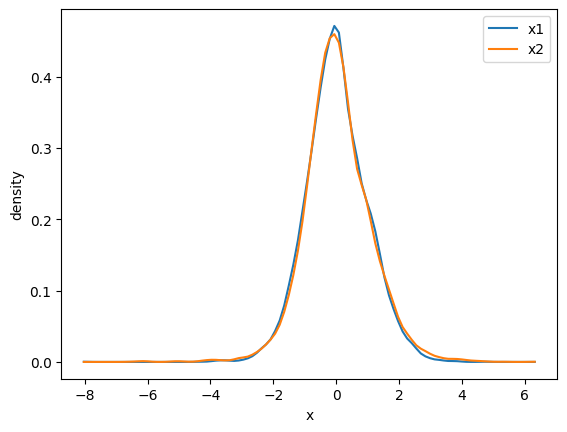

In [21]:
from scipy.stats import gaussian_kde

# TODO: Make code that automatically slices these up.
theta_test = jnp.expand_dims(X[:, X.shape[1] // 2], -1)
# d_test = jnp.expand_dims(X[:, 4], -1)
d_test = X[:, -len_x:-len_xi]
xi_test = X[:, -len_xi:]
# xi_test = jnp.expand_dims(X[:, 2], -1)
# xi_test = jnp.ones((10000, 1)) * 3
# xi_test = jnp.expand_dims(X[:, 1], -1)


samples = model_sample.apply(params, 
                    next(prng_seq),
                    num_samples=len(theta_test),
                    theta=theta_test,
                    d=d_test,
                    # d=d_obs,
                    xi=xi_test)


density_1 = gaussian_kde(samples[:, 0])
density_2 = gaussian_kde(samples[:, 1])


# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(samples), jnp.max(samples), 100)
ax.plot(x, density_1(x), label='x1')
ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()

## Regular ACE
Really just copy/paste of AF's implementation in `pyro`. Since the current `pyro` release doesn't have some of AF's code from SGBOED, have to copy/paste some of his custom functions here.

Going to compare the lower/upper bounds of SGBOED on a simple linear regression task. 

In [12]:
import time
import numbers
import math

import torch
from torch import nn
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro import poutine
from pyro.contrib.util import rmv, lexpand

def is_bad(a):
    return torch_isnan(a) or torch_isinf(a)
    

def torch_isnan(x):
    """
    A convenient function to check if a Tensor contains any nan; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x != x
    return torch.isnan(x).any()


def torch_isinf(x):
    """
    A convenient function to check if a Tensor contains any +inf; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x == float('inf') or x == -float('inf')
    return (x == float('inf')).any() or (x == -float('inf')).any()


def _safe_mean_terms(terms):
    mask = torch.isnan(terms) | (terms == float('-inf')) | (terms == float('inf'))
    if terms.dtype is torch.float32:
        nonnan = (~mask).sum(0).float()
    elif terms.dtype is torch.float64:
        nonnan = (~mask).sum(0).double()
    terms[mask] = 0.
    loss = terms.sum(0) / nonnan
    agg_loss = loss.sum()
    return agg_loss, loss


def make_regression_model(w_loc, w_scale, sigma_scale, xi_init, observation_label="y"):
    def regression_model(design_prototype):
        design = pyro.param("xi", xi_init)
        design = (design / design.norm(dim=-1, p=1, keepdim=True)).expand(design_prototype.shape)
        if is_bad(design):
            raise ArithmeticError("bad design, contains nan or inf")
        batch_shape = design.shape[:-2]
        with pyro.plate_stack("plate_stack", batch_shape):
            # `w` is shape p, the prior on each component is independent
            w = pyro.sample("w", dist.Laplace(w_loc, w_scale).to_event(1))
            # `sigma` is scalar
            sigma = 1e-6 + pyro.sample("sigma", dist.Exponential(sigma_scale)).unsqueeze(-1)
            mean = rmv(design, w)
            sd = sigma
            y = pyro.sample(observation_label, dist.Normal(mean, sd).to_event(1))
            return y

    return regression_model


class TensorLinear(nn.Module):
    __constants__ = ['bias']

    def __init__(self, *shape, bias=True):
        super(TensorLinear, self).__init__()
        self.in_features = shape[-2]
        self.out_features = shape[-1]
        self.batch_dims = shape[:-2]
        self.weight = nn.Parameter(torch.Tensor(*self.batch_dims, self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(*self.batch_dims, self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return rmv(self.weight, input) + self.bias


class PosteriorGuide(nn.Module):
    def __init__(self, y_dim, w_dim, batching):
        super(PosteriorGuide, self).__init__()
        n_hidden = 64
        self.linear1 = TensorLinear(*batching, y_dim, n_hidden)
        self.linear2 = TensorLinear(*batching, n_hidden, n_hidden)
        self.output_layer = TensorLinear(*batching, n_hidden, w_dim + 3)
        self.covariance_shape = batching + (w_dim, w_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

    def forward(self, y_dict, design_prototype, observation_labels, target_labels):
        y = y_dict["y"] - .5
        x = self.relu(self.linear1(y))
        x = self.relu(self.linear2(x))
        final = self.output_layer(x)

        posterior_mean = final[..., :-3]
        gamma_concentration = 1e-6 + self.softplus(final[..., -3])
        gamma_rate = 1. + self.softplus(final[..., -2])
        scale_tril_multiplier = 1e-6 + self.softplus(final[..., -1])

        pyro.module("posterior_guide", self)

        posterior_scale_tril = pyro.param(
            "posterior_scale_tril",
            torch.eye(posterior_mean.shape[-1], device=posterior_mean.device).expand(self.covariance_shape),
            constraint=constraints.lower_cholesky
        )
        posterior_scale_tril = posterior_scale_tril * scale_tril_multiplier.unsqueeze(-1).unsqueeze(-1)

        batch_shape = design_prototype.shape[:-2]
        with pyro.plate_stack("guide_plate_stack", batch_shape):
            pyro.sample("sigma", dist.Gamma(gamma_concentration, gamma_rate))
            pyro.sample("w", dist.MultivariateNormal(posterior_mean, scale_tril=posterior_scale_tril))


def _ace_eig_loss(model, guide, M, observation_labels, target_labels):
    def loss_fn(design, num_particles, evaluation=False, **kwargs):
        N = num_particles
        expanded_design = lexpand(design, N)
        
        # Sample from p(y, theta | d)
        trace = poutine.trace(model).get_trace(expanded_design)
        y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
        y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
        theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

        trace.compute_log_prob()
        marginal_terms_cross = sum(trace.nodes[l]["log_prob"] for l in target_labels)
        marginal_terms_cross += sum(trace.nodes[l]["log_prob"] for l in observation_labels)

        reguide_trace = poutine.trace(
            pyro.condition(guide, data=theta_dict)).get_trace(
            y_dict, expanded_design, observation_labels, target_labels)
        # Here's a spot where you could update each model's parameters based on log_prob
        reguide_trace.compute_log_prob()
        marginal_terms_cross -= sum(reguide_trace.nodes[l]["log_prob"] for l in target_labels)

        # Sample M times from q(theta | y, d) for each y
        reexpanded_design = lexpand(expanded_design, M)
        guide_trace = poutine.trace(guide).get_trace(
            y_dict, reexpanded_design, observation_labels, target_labels
        )
        theta_y_dict = {l: guide_trace.nodes[l]["value"] for l in target_labels}
        theta_y_dict.update(y_dict_exp)
        guide_trace.compute_log_prob()

        # Re-run that through the model to compute the joint
        model_trace = poutine.trace(
            pyro.condition(model, data=theta_y_dict)).get_trace(reexpanded_design)
        model_trace.compute_log_prob()

        marginal_terms_proposal = -sum(guide_trace.nodes[l]["log_prob"] for l in target_labels)
        marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in target_labels)
        marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in observation_labels)

        marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
        terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

        # At eval time, add p(y | theta, d) terms
        if evaluation:
            terms += sum(trace.nodes[l]["log_prob"] for l in observation_labels)
        return _safe_mean_terms(terms)

    return loss_fn


def neg_loss(loss):
    def new_loss(*args, **kwargs):
        return (-a for a in loss(*args, **kwargs))
    return new_loss


def opt_eig_loss_w_history(design, loss_fn, num_samples, num_steps, optim, time_budget):
    params = None
    est_loss_history = []
    xi_history = []
    baseline = 0.
    t = time.time()
    wall_times = []
    for step in range(num_steps):
        if params is not None:
            pyro.infer.util.zero_grads(params)
        with poutine.trace(param_only=True) as param_capture:
            agg_loss, loss = loss_fn(design, num_samples, evaluation=True, control_variate=baseline)
        baseline = -loss.detach()
        params = set(site["value"].unconstrained()
                     for site in param_capture.trace.nodes.values())
        if torch.isnan(agg_loss):
            raise ArithmeticError("Encountered NaN loss in opt_eig_ape_loss")
        agg_loss.backward(retain_graph=True)
        est_loss_history.append(loss.detach())
        wall_times.append(time.time() - t)
        optim(params)
        optim.step()
        print(pyro.param("xi")[0, 0, ...])
        print(step)
        print('eig', baseline.squeeze())
        if time_budget and time.time() - t > time_budget:
            break

    xi_history.append(pyro.param('xi').detach().clone())

    est_loss_history = torch.stack(est_loss_history)
    xi_history = torch.stack(xi_history)
    wall_times = torch.tensor(wall_times)

    return xi_history, est_loss_history, wall_times


# --------------------
# Start Pyro code implementation
num_steps = 1000
num_samples = 10
time_budget = 1000
seed = 420
num_parallel = 1
start_lr = 0.001
end_lr = 0.001
device = 'cpu'
n = 20
p = 1
scale = 1.

pyro.clear_param_store()
if seed >= 0:
    pyro.set_rng_seed(seed)
else:
    seed = int(torch.rand(tuple()) * 2 ** 30)
    pyro.set_rng_seed(seed)

xi_init = torch.randn((num_parallel, n, p), device=device)
# Change the prior distribution here
# prior params
w_prior_loc = torch.zeros(p, device=device)
w_prior_scale = scale * torch.ones(p, device=device)
sigma_prior_scale = scale * torch.tensor(1., device=device)

model_learn_xi = make_regression_model(
    w_prior_loc, w_prior_scale, sigma_prior_scale, xi_init)

contrastive_samples = num_samples

# Fix correct loss
targets = ["w", "sigma"]

guide = PosteriorGuide(n, p, (num_parallel,)).to(device)
eig_loss = _ace_eig_loss(model_learn_xi, guide, contrastive_samples, ["y"], targets)
loss = neg_loss(eig_loss)

gamma = (end_lr / start_lr) ** (1 / num_steps)
scheduler = pyro.optim.ExponentialLR({'optimizer': torch.optim.Adam, 'optim_args': {'lr': start_lr},
                                        'gamma': gamma})

design_prototype = torch.zeros(num_parallel, n, p, device=device)  # this is annoying, code needs refactor

xi_history, est_loss_history, wall_times = opt_eig_loss_w_history(
    design_prototype, loss, num_samples=num_samples, num_steps=num_steps, optim=scheduler,
    time_budget=time_budget)

est_eig_history = -est_loss_history

results = {'seed': seed, 'xi_history': xi_history.cpu(), 'est_eig_history': est_eig_history.cpu(),
            'wall_times': wall_times.cpu()}

tensor([-0.0070], grad_fn=<SelectBackward0>)
0
eig tensor(2.2699)
tensor([-0.0070], grad_fn=<SelectBackward0>)
1
eig tensor(1.3538)
tensor([-0.0070], grad_fn=<SelectBackward0>)
2
eig tensor(1.0857)
tensor([-0.0070], grad_fn=<SelectBackward0>)
3
eig tensor(-0.7965)
tensor([-0.0070], grad_fn=<SelectBackward0>)
4
eig tensor(1.3518)
tensor([-0.0070], grad_fn=<SelectBackward0>)
5
eig tensor(-0.1831)
tensor([-0.0070], grad_fn=<SelectBackward0>)
6
eig tensor(0.8764)
tensor([-0.0070], grad_fn=<SelectBackward0>)
7
eig tensor(1.7372)
tensor([-0.0070], grad_fn=<SelectBackward0>)
8
eig tensor(2.0288)
tensor([-0.0070], grad_fn=<SelectBackward0>)
9
eig tensor(2.0209)
tensor([-0.0070], grad_fn=<SelectBackward0>)
10
eig tensor(1.4414)
tensor([-0.0070], grad_fn=<SelectBackward0>)
11
eig tensor(1.3914)
tensor([-0.0070], grad_fn=<SelectBackward0>)
12
eig tensor(-0.4504)
tensor([-0.0070], grad_fn=<SelectBackward0>)
13
eig tensor(0.1036)
tensor([-0.0070], grad_fn=<SelectBackward0>)
14
eig tensor(0.9313)
te

In [10]:
results.keys()

dict_keys(['seed', 'xi_history', 'est_eig_history', 'wall_times'])

## LFI-ACE
Manually trained and stepped-through LFI-ACE model.

1. Approximate likelihood using normalizing flow. Use a bunch of samples and their corresponding $\theta$ values. Also, since the `pyro` version only uses one noise element, get rid of the other one that Kleinegesse used.
2. Use approximated likelihood in ACE computation.

In [18]:
def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    ''' Linear regression simulator in jax using distrax.'''
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # # sample random gamma noise
    # n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
    #     seed=keys[1], sample_shape=[len(d), len(priors)]
    # )

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:, 1], 0)
    # y = y + n_g + jnp.squeeze(n_n)
    y = y + jnp.squeeze(n_n)
    ygrads = priors[:, 1]

    return y, ygrads


def sim_data(d: Array, num_samples: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)

    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y, ygrads = sim_linear_jax(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


Time to train. Just need a vector of the samples and thetas that produced them. Don't need a simulator or the prior quite yet.
- How do I track the training curves in Jax/Haiku? Gave in and am using WANDB.

In [42]:
import wandb

wandb.init(project="lfiax_linRegression_ACE", entity="vz_uci")

# TODO: Put this in hydra config file
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.0, 0.0, 5.0, 10.0])
# d = jnp.array([1., 2.])
# d = jnp.array([1.])
d_obs = jnp.array([1.0])
# d_obs = jnp.array([])
# d_prop = jrandom.uniform(key, shape=(1,), minval=-10.0, maxval=10.0)
d_sim = jnp.concatenate((d_obs, d_prop), axis=0)
len_x = len(d_sim)
len_d = len(d_obs)
len_xi = len(d_prop)

# Params and hyperparams
theta_shape = (2,)
d_shape = (len(d_obs),)
xi_shape = (len_xi,)
EVENT_SHAPE = (len(d_sim),)
# EVENT_DIM is important for the normalizing flow's block.
EVENT_DIM = 1
cond_info_shape = (theta_shape[0], len_d, len_xi)

batch_size = 128
flow_num_layers = 10
mlp_num_layers = 4
hidden_size = 500
num_bins = 4
learning_rate = 1e-4

training_steps = 1000
eval_frequency = 100

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": training_steps,
  "batch_size": batch_size,
  "flow_num_layers": flow_num_layers,
  "mlp_num_layers": mlp_num_layers,
  "hidden_size": hidden_size,
  "num_bins": num_bins,
  "num_samples": num_samples,
  "optimizer": "adam",
  "xi": d_prop,
  "x": d_sim
}

optimizer = optax.adam(learning_rate)

# Simulating the data to be used to train the flow.
num_samples = 10000
# TODO: put this function in training since d will be changing.
X = sim_data(d_sim, num_samples, key)

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
opt_state = optimizer.init(params)

for step in range(training_steps):
    params, opt_state, grads_d = update(
        params, next(prng_seq), opt_state, next(train_ds)
    )

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")
        
        wandb.log({"loss": val_loss, "step": step})

        # Optional
        # wandb.watch(model)



loss,▇▆█▁▇▂█▆▃▄
step,▁▂▃▃▄▅▆▆▇█
loss,3.5908
step,900


STEP:     0; Validation loss: 3.576
STEP:   100; Validation loss: 3.659
STEP:   200; Validation loss: 3.628
STEP:   300; Validation loss: 3.580
STEP:   400; Validation loss: 3.629
STEP:   500; Validation loss: 3.598
STEP:   600; Validation loss: 3.595
STEP:   700; Validation loss: 3.628
STEP:   800; Validation loss: 3.600
STEP:   900; Validation loss: 3.600


In [45]:
d_prop

DeviceArray([-0.05977392], dtype=float32)

In [46]:
d_prop.shape

(1,)

Making the sampling/log-prob stuff work. Now to actually implment LFI ACE. I've got the flow, now just going to do some of the ACE computations manually.

In [ ]:
def jax_lexpand(A, *dimensions):
    """Expand tensor, adding new dimensions on left."""
    if jnp.isscalar(A):
        A = A * jnp.ones(dimensions)
        return A
    shape = tuple(dimensions) + A.shape
    A = A[jnp.newaxis, ...]
    A = jnp.broadcast_to(A, shape)
    return A


# Walking through and commenting the code
def lfi_ace_eig_loss(model:NormalizingFlow, guide:NormalizingFlow, M, observation_labels, target_labels):
    def loss_fn(design, num_particles, evaluation=False, **kwargs):
        N = num_particles
        # Expand to the number of parallel designs being evaluated
        expanded_design = lexpand(design, N)
        
        # TODO: make a for loop over the proposed models here.
        for model in models:
            # TODO: would be cool to make sampling from the model's prior a method
             # Hmm I need N copies for parallelization. I can figure that out later, though.
            model_thetas_0 = model.prior_distribution.sample(num_samples)
            y_0, log_prob_y_0 = model.sample_with_log_prob(model_thetas_0, expanded_design)
            # Get a dictionary of the expanded y and theta values, just make M copies of y values
            # TODO: think of a better way to add these into expanded dictionary values...
            y_dict_exp = lexpand(y, M)

            # This is essentially the p(y|theta)p(theta)
            # Ohh, each model will have two ratios, it's current prob and its prior one
            marginal_terms_cross = sum(model.prior_distribution.log_prob(model_thetas_0))
            marginal_terms_cross += sum(log_prob_y_0)

        # Pray that jax can handle this parallelization - vmap and pmap to the rescue!...?
        for _ in range(m):
            for model in models:
                # Sample from q(theta | y, d) using the guide normalizing flow
                theta, log_prob = guide.sample_with_log_prob(y, expanded_design, observation_labels, target_labels)
                theta_y_dict = {l: theta[l] for l in target_labels}
                theta_y_dict.update(y_dict_exp)

                marginal_terms_proposal = -sum(log_prob[l] for l in target_labels)
                marginal_terms_proposal += sum(log_prob[l] for l in target_labels)
                marginal_terms_proposal += sum(log_prob[l] for l in observation_labels)

                marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
                terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

                # At eval time, add p(y | theta, d) terms
                if evaluation:
                    terms += sum(log_prob[l] for l in observation_labels)
                return _safe_mean_terms(terms)

        # Sample from q(theta | y, d) using the guide normalizing flow
        theta, log_prob = guide.sample_with_log_prob(y, expanded_design, observation_labels, target_labels)
        theta_y_dict = {l: theta[l] for l in target_labels}
        theta_y_dict.update(y_dict_exp)

        marginal_terms_proposal = -sum(log_prob[l] for l in target_labels)
        marginal_terms_proposal += sum(log_prob[l] for l in target_labels)
        marginal_terms_proposal += sum(log_prob[l] for l in observation_labels)

        marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
        terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

        # At eval time, add p(y | theta, d) terms
        if evaluation:
            terms += sum(log_prob[l] for l in observation_labels)
        return _safe_mean_terms(terms)

    return loss_fn


In [111]:
device = 'cpu'
p = 20
n = 20
N = 2 # num_parallel
M = 2
design = torch.zeros([10, 20, 20])
expanded_design = lexpand(design, N)

w_prior_loc = torch.zeros(p, device=device)
w_prior_scale = scale * torch.ones(p, device=device)
sigma_prior_scale = scale * torch.tensor(1., device=device)

model_learn_xi = make_regression_model(
    w_prior_loc, w_prior_scale, sigma_prior_scale, xi_init)

model = model_learn_xi
guide = PosteriorGuide(n, p, (N,)).to(device)
observation_labels = ["y"]
target_labels = ['w', 'sigma']

In [91]:
trace = poutine.trace(model).get_trace(expanded_design)
y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

In [101]:
y_dict['y'].shape

torch.Size([2, 10, 20])

In [104]:
theta_dict['w'].shape

torch.Size([2, 10, 20])

In [105]:
theta_dict['sigma'].shape

torch.Size([2, 10])

In [107]:
[trace.nodes[l]["log_prob"].shape for l in target_labels]

[torch.Size([2, 10]), torch.Size([2, 10])]

That's what's throwing me off. Determining the `log_prob` of the `w` vector compresses it for some reason... Oh, wait, it's the probability of each *vector*. That's why it's compressed to the shape of the `y` and `sigma` shapes. Yea, that makes a lot more sense.

In [92]:
trace.compute_log_prob()
# This is taking the log_prob of a vector from a distribution. I can either use a distribution that 
# is in a vector format or I think it should be fine to add two separate ones together...
marginal_terms_cross = sum(trace.nodes[l]["log_prob"] for l in target_labels)

In [108]:
marginal_terms_cross += sum(trace.nodes[l]["log_prob"] for l in observation_labels)

In [109]:
marginal_terms_cross

tensor([[-48.1695, -70.6690, -58.5410, -57.8346, -82.7463, -79.5401, -34.3802,
         -75.5568, -62.8853, -90.3731],
        [-68.9690, -46.9697, -79.1669, -81.4540, -75.3442, -28.8084, -77.4504,
         -67.5315,   2.8248, -70.4339]], grad_fn=<AddBackward0>)

This next part would be the denominator of LFI-ACE with the sum of all of the models' log_probs. The numerator might actually be the sum of all the log_probs. The denominator would be the weighted sum... Yea, that makes more sense....

Part of the loss could then just be adding on the loss of the prediction of each normalizing flow. That makes one scalar loss. Although, there's an EIG for each of the 'y' outputs, too.

In [112]:
reguide_trace = poutine.trace(
    pyro.condition(guide, data=theta_dict)).get_trace(
    y_dict, expanded_design, observation_labels, target_labels)
# Here's a spot where you could update each model's parameters based on log_prob
reguide_trace.compute_log_prob()
marginal_terms_cross -= sum(reguide_trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_cross

RuntimeError: The size of tensor a (2) must match the size of tensor b (10) at non-singleton dimension 1
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
trace = poutine.trace(model).get_trace(expanded_design)
y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

trace.compute_log_prob()
marginal_terms_cross = sum(trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_cross += sum(trace.nodes[l]["log_prob"] for l in observation_labels)

reguide_trace = poutine.trace(
    pyro.condition(guide, data=theta_dict)).get_trace(
    y_dict, expanded_design, observation_labels, target_labels)
# Here's a spot where you could update each model's parameters based on log_prob
reguide_trace.compute_log_prob()
marginal_terms_cross -= sum(reguide_trace.nodes[l]["log_prob"] for l in target_labels)

# Sample M times from q(theta | y, d) for each y
reexpanded_design = lexpand(expanded_design, M)
guide_trace = poutine.trace(guide).get_trace(
    y_dict, reexpanded_design, observation_labels, target_labels
)
theta_y_dict = {l: guide_trace.nodes[l]["value"] for l in target_labels}
theta_y_dict.update(y_dict_exp)
guide_trace.compute_log_prob()

# Re-run that through the model to compute the joint
model_trace = poutine.trace(
pyro.condition(model, data=theta_y_dict)).get_trace(reexpanded_design)
model_trace.compute_log_prob()

marginal_terms_proposal = -sum(guide_trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in observation_labels)

marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

# At eval time, add p(y | theta, d) terms
# if evaluation:
terms += sum(trace.nodes[l]["log_prob"] for l in observation_labels)
# breakpoint()
_safe_mean_terms(terms)


In [66]:
testy_d = jnp.array([3.])

(10, 1)

In [78]:
jnp.isscalar(testy_d)

AttributeError: 'bool' object has no attribute 'shape'

In [119]:
from jax import pmap, vmap

def compute1(x):
  return x ** 2

def compute2(x):
  return x ** 3

functions = [compute1, compute2]

# create a vmap function that takes a function and an array as input
vmap_fun = vmap(lambda f, x: jnp.vectorize(f)(x))

# apply the vmap function to the list of functions and the range of inputs
result = pmap(vmap_fun)(functions, range(10))

print(result)


ValueError: pmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())